![Total](Methods/Code_detection/img/total.jpg)

In [3]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset Preprocessing 

Change dataset format

In [1]:
import pandas as pd
import json

def csv_to_jsonl_split(input_path: str, 
                       output_human_path: str, 
                       output_llm_path: str):
    '''
    
    '''
    ds = pd.read_csv(input_path)

    # colonna da tenere
    CODE_CONLUMN = "cleared_code"       # <-- la feature che vuoi salvare
    SPLIT = "LLM"        # <-- la colonna che decide dove va il sample
    target = "Human"              # <-- valore discriminante

    ds = pd.read_csv(input_path)

    # split dataset
    dataset_match = ds[ds[SPLIT] == target]
    dataset_other = ds[ds[SPLIT] != target]

    # salva human.jsonl
    with open(output_human_path, "w", encoding="utf-8") as f:
        for _, row in dataset_match.iterrows():
            f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")

    # salva llm.jsonl
    with open(output_llm_path, "w", encoding="utf-8") as f:
        for _, row in dataset_other.iterrows():
            f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")


In [ ]:
INPUT_PATH = './Dataset/AIGCodeSet.csv'
HUMAN_PATH = "./Methods/DetectGPT4Code/results/AIGCodeSethuman.json"
LLM_PATH = "./Methods/DetectGPT4Code/results/AIGCodeSetllm.json"

In [3]:
csv_to_jsonl_split(input_path = INPUT_PATH, 
                    output_human_path = HUMAN_PATH, 
                    output_llm_path = LLM_PATH)

![FIM](Methods/Code_detection/img/FIM.jpg)

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch, json
import random, os
from Methods.DetectGPT4Code.utils_batch import InfillingModel
import tqdm

def run_fill_in_the_middle(
    input_path,                # es: "gpt4_python_codecontest.jsonl"
    output_path="./Methods/DetectGPT4Code/results/fim.josnl", 
    batch_size=20,
    mask_lines=1,
    model_name="facebook/incoder-6B",
    code_lable = 'cleared_code',
    device = DEVICE
):
    """
    input_path: must be a .jsonl
    Esegue la perturbazione FIM su un dataset JSONL con campo 'code_lable'.
    Salva un nuovo JSONL con campo 'fill_in_middle_gold'.
    """
    


    # half precision solo per incoder-6B
    half = True if model_name == "facebook/incoder-6B" else False
    
    infilling_model = InfillingModel(model_name=model_name, cuda=True, half=half, device=device, quantization = "nf4")

    # upload dataset
    with open(input_path, 'r', encoding="utf-8") as f:
        dataset = [json.loads(line) for line in f.readlines()]

    # support functions
    def find_all(substring, string):
        start = 0
        while True:
            start = string.find(substring, start)
            if start == -1: return
            yield start
            start += len(substring)

    def mask_code(parsed_code, mask_lines=mask_lines):
        for _ in range(mask_lines):
            positions = list(find_all(substring='\n', string=parsed_code))
            if positions == []:
                positions = list(find_all(substring=':', string=parsed_code))
            if len(positions) < 2:
                continue
            mask_start = random.choice(range(len(positions)-1))
            mask_start_position = positions[mask_start]
            mask_end_position = positions[mask_start+1]
            parsed_code = parsed_code[:mask_start_position] + '<insert>' + parsed_code[mask_end_position:]
        return parsed_code

    def norm_inserts_num(parsed_code_norm):
        max_num = 0
        for i, x in enumerate(parsed_code_norm):
            if len(list(find_all('<insert>', x))) > max_num:
                max_num = len(list(find_all('<insert>', x)))
                id = i

        new_res = []
        for x in parsed_code_norm:
            if len(list(find_all('<insert>', x))) < max_num:
                new_res.append(parsed_code_norm[id])
            else:
                new_res.append(x)
        return new_res
    ## end support function
    

    # output check
    if os.path.exists(output_path):
        with open(output_path, 'r') as f:
            finished = [json.loads(line) for line in f.readlines()]
        dataset = dataset[len(finished):]


    # MAIN CYCLE
    for idx, ins in tqdm.tqdm(enumerate(dataset), total=len(dataset)):
        code_lable_all = []
        if len(ins[code_lable]) < 2500:
            for _ in range(batch_size):
                gold_codes_masked = mask_code(ins[code_lable], mask_lines=mask_lines)
                code_lable_all.append(gold_codes_masked[:2500])

            code_lable_all = norm_inserts_num(code_lable_all)
            parts_batch = [example.split("<insert>") for example in code_lable_all]
            fill_in_middle_gold = infilling_model.batched_infill(
                parts_batch, max_to_generate=16*mask_lines, temperature=0.7
            )
            ins['fill_in_middle_gold'] = fill_in_middle_gold
        else:
            ins['fill_in_middle_gold'] = ['token exceeds 2500']

        with open(output_path, 'a') as f:
            f.write(json.dumps(ins) + '\n')
    

    return output_path


In [ ]:
HUMANfim = "./Methods/DetectGPT4Code/results/8HUMANfim.jsonl"
LLMfim = "./Methods/DetectGPT4Code/results/8LLMfim.jsonl"
fim_model = "facebook/incoder-1B"
code_conlumn = 'cleared_code'  

In [ ]:
run_fill_in_the_middle(
    input_path = HUMAN_PATH,
    output_path = HUMANfim, 
    batch_size =10,
    mask_lines =8,
    model_name = fim_model,
    code_lable = code_conlumn,
    device = DEVICE
)

In [ ]:
run_fill_in_the_middle(
    input_path = LLM_PATH,
    output_path = LLMfim, 
    batch_size =10,
    mask_lines =8,
    model_name = fim_model,
    code_lable = code_conlumn,
    device = DEVICE
)

## Testing

![Grafico dei risultati](Methods/Code_detection/img/PolyCoder.jpg)

In [1]:
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_name = 'NinedayWang/PolyCoder-160M'
PyCodeGPT = AutoModelForCausalLM.from_pretrained(model_name).to(DEVICE)
PyCodeGPT_tokenizer = AutoTokenizer.from_pretrained( model_name )

CONFIG = AutoConfig.from_pretrained(model_name)
# Get the default max_length
MAX_LENGTH = CONFIG.max_position_embeddings
print(f"max length: {MAX_LENGTH}")


HUMAN = "./Methods/DetectGPT4Code/results/8HUMANfim.jsonl"

max length: 2048


In [2]:
import numpy as np
from torch.nn.functional import log_softmax

inputs = 'this is a test'
truncate_ratio=0.9
def get_logprob(inputs, 
                tokenizer = PyCodeGPT_tokenizer, 
                model = PyCodeGPT, 
                max_length=MAX_LENGTH, 
                device = DEVICE 
                ):
    '''
    '''

    input_ids = tokenizer.encode(inputs, return_tensors='pt').to(DEVICE)
    input_ids = input_ids[:, :max_length]

    with torch.no_grad():
        output = model(input_ids)
    logits = output[0]

    # Assuming the `logits` tensor contains the output from the model
    log_probs = log_softmax(logits, dim=-1)
    # Select the log probabilities for the specific tokens in the input
    input_log_probs = log_probs[0, torch.arange(log_probs.size(1)), input_ids[0]]
    # Multiply by -1 to get the negative log probabilities
    neg_log_probs = -input_log_probs
    neg_log_probs = neg_log_probs.cpu().numpy().tolist()
    return np.average( neg_log_probs[int( truncate_ratio*len(neg_log_probs)): ] ), neg_log_probs

In [3]:
avg_neg_log_probs, neg_log_probs = get_logprob('this is a test')
neg_log_probs[-500:]
avg_neg_log_probs

np.float64(6.511268615722656)

data

In [4]:
import json

def read_jsonl_selected(path_jsonl, keys_to_keep=None):
    """
    Legge un file JSONL e restituisce una lista di dict contenenti 
    solo le chiavi specificate in keys_to_keep.
    Se keys_to_keep è None, restituisce l'intero dict.
    """
    data = []
    with open(path_jsonl, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            if keys_to_keep is not None:
                filtered = {k: obj[k] for k in keys_to_keep if k in obj}
                data.append(filtered)
            else:
                data.append(obj)
    return data




In [29]:
rows_HUMAN = read_jsonl_selected('./Methods/DetectGPT4Code/results/8HUMANfim.jsonl', keys_to_keep=["cleared_code", "fill_in_middle_gold"])
rows_LLM = read_jsonl_selected('./Methods/DetectGPT4Code/results/8LLMfim.jsonl', keys_to_keep=["cleared_code", "fill_in_middle_gold"])

print(rows_HUMAN[0])

{'cleared_code': 'import sys\nimport numpy as np\nn, t = map(int, input().split())\nknapsack = np.zeros(t, dtype=np.int64)\ncuisines = [tuple(map(int, line.split())) for line in sys.stdin]\ncuisines.sort()\ntmp_ans = 0\nfor a, b in cuisines:\n    tmp_ans = max(tmp_ans, knapsack.max() + b)\n    knapsack[a:] = np.maximum(knapsack[a:], knapsack[:-a] + b)\nprint(max(tmp_ans, knapsack.max()))\n', 'fill_in_middle_gold': [{'text': 'import sys\nt = int(sys.argv[1])\nknapsack = np.zeros(t, dtype=np.int64)\ncuisines = sorted(set(cuisines))\ncuisines.sort()\nfor cuisine in cuisines:\n    mask = cuisines == cuisine\n    knapsack[mask] += t[mask]\n\nprint knapsack\n\n<|/ file source=github filename=knapsack.py \n', 'parts': ['import sys', '', '\nknapsack = np.zeros(t, dtype=np.int64)', '\ncuisines.sort()', '', '', '', '\n'], 'infills': ['\nt = int(', 'sys.argv[1])', '\ncuisines = sorted(set(cuisines))', '\nfor cuisine in cuisines:\n', '    mask = cuisines == cuisine\n    knapsack[mask] += t[mask]\n

In [35]:
### TEST
def γ_application(s: str, γ: float = 90) -> str:
    total = 1-γ
    if not s:  # stringa vuota
        return ""
    n = max(5, len(s) // total)  # almeno 1 carattere
    return s[-n:]

print(γ_application("hello world, how are you? i am ok", γ=99))

am ok


In [45]:
import tqdm


def prob_difference(rows: dict, γ: float = 90) -> list:

    '''
    '''
    def γ_application(s: str, γ: float = 90) -> str:
        total = 1-γ
        if not s:  # stringa vuota
            return ""
        n = max(5, len(s) // total)  # almeno 1 carattere
        return s[-n:]

    gold_prob_all = []
    no_dict = 0
    no_code = 0
    no_fill_in_middle = 0
    no_fill_completed = 0

    print("Starting processing...")
    print(f"Total rows: {len(rows)}")

    for i, row in tqdm.tqdm(enumerate(rows), total=len(rows)):

        # prendi l'originale: preferisci cleared_code, altrimenti code
        if not isinstance(row, dict):
            no_dict += 1
            continue



        gold = row.get("cleared_code") or row.get("code")
        gold = γ_application(gold)
        if not gold:
            no_code += 1
            continue

        if not row.get("fill_in_middle_gold"):
            no_fill_in_middle += 1
            continue

        # THE MAIN PART
        fim_completed = [γ_application(f.get("text"), γ=γ) for f in row.get("fill_in_middle_gold") 
                            if isinstance(f, dict) and f.get("completed", False) and "text" in f]

        if len(fim_completed) < 8 or fim_completed is None:
            no_fill_completed += 1
            continue

        # stesso schema: score originale - media(score perturbazioni)
        original_score = get_logprob(gold)[0]

        miu_scores = [get_logprob(text)[0] for text in fim_completed]
        miu_scores_average_score = float(np.mean(miu_scores))

        gold_prob_all.append(original_score - miu_scores_average_score)

    print(f"Processed | no_dict: {no_dict}, no_code: {no_code}, no_fill_in_middle: {no_fill_in_middle}, no_fill_completed: {no_fill_completed}")

    return gold_prob_all 




In [46]:
prob_HUMAN = prob_difference(rows_HUMAN, γ=95)
prob_LLM = prob_difference(rows_LLM,γ=95)

print(float(np.mean(prob_HUMAN)))
print(float(np.mean(prob_LLM)))

Starting processing...
Total rows: 249


100%|██████████| 249/249 [00:08<00:00, 28.13it/s]


Processed | no_dict: 0, no_code: 0, no_fill_in_middle: 0, no_fill_completed: 141
Starting processing...
Total rows: 747


100%|██████████| 747/747 [00:28<00:00, 26.62it/s]

Processed | no_dict: 0, no_code: 0, no_fill_in_middle: 0, no_fill_completed: 386
-0.2909950886642246
-0.24633107770586354


[np.float64(-1.566263688935174), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.3875662922859191), np.float64(-2.562360498640272), np.float64(0.0), np.float64(-1.753874349594116), np.float64(0.0), np.float64(-0.44921538829803476), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.1544365485509238), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-1.0925505995750426), np.float64(0.0), np.float64(-0.9182751655578612), np.float64(0.0), np.float64(-0.45068889194064665), np.float64(-1.592025566101074), np.float64(0.0), np.float64(-0.5066150695085527), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(-0.33357482486300993), np.float64(0.05563492178916929), np.float64(-1.38081271648407), np.float64(0.0), np.float64(0.0), np.float64(0.

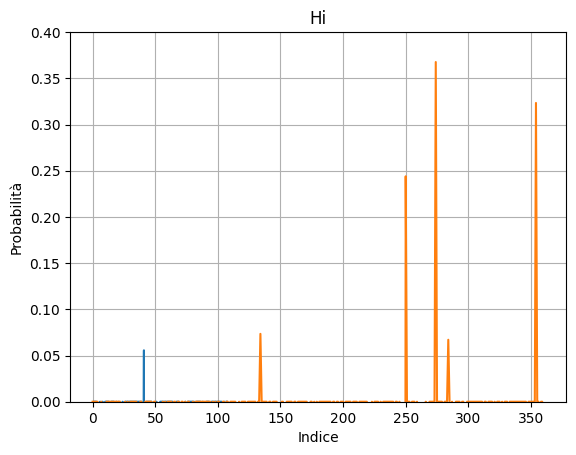

In [47]:
import matplotlib.pyplot as plt

print(prob_HUMAN)
plt.figure()
plt.plot(np.arange(len(prob_HUMAN)), prob_HUMAN)
plt.plot(np.arange(len(prob_LLM)), prob_LLM)
plt.ylim(0, 0.4)               # scala verticale 0–1
plt.xlabel("Indice")
plt.ylabel("Probabilità")
plt.title('Hi')
plt.grid(True)
plt.show()

469 469


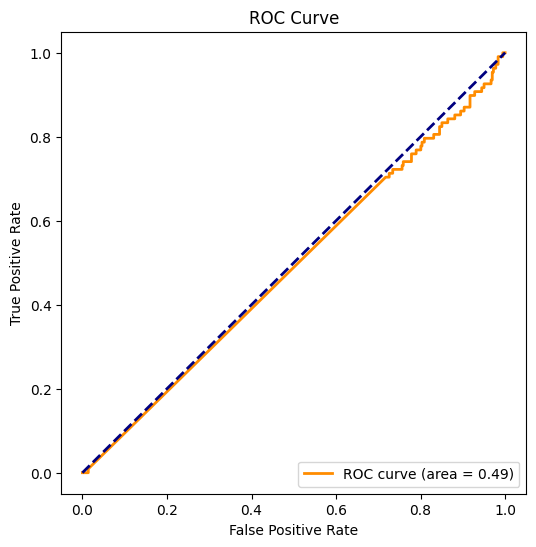

In [60]:
# pseudo classification 
from sklearn.metrics import auc, roc_curve


k = -0.26
TP = sum(x > k for x in prob_HUMAN)
FP = sum(x <= k for x in prob_LLM)

TN = sum(x > k for x in prob_LLM)
FN = sum(x <= k for x in prob_HUMAN)



ones = [1] * len(prob_HUMAN)
zero = [0] * len(prob_LLM)


y_true = ones + zero
y_scores  = prob_HUMAN + prob_LLM

print(len(y_true), len(y_scores))




# Calcolo ROC
fpr, tpr, soglie = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Disegno
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

